In [1]:
#Fill these file paths with the locations on your machine. 
PATH_TO_CODE = 'C:/Users/blake/OneDrive/Desktop/Computer Vision/Project/pastis-benchmark/code' # path to the code folder of the repo
PATH_TO_PASTIS = 'D:/PASTIS'


import sys
sys.path.append(PATH_TO_CODE)


import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib

cm = matplotlib.colormaps['tab20']
def_colors = cm.colors
cus_colors = ['k'] + [def_colors[i] for i in range(1,20)]+['w']
cmap = ListedColormap(colors = cus_colors, name='agri',N=21)

def get_rgb(x, batch_index=0, t_show=1):
    """Utility function to get a displayable rgb image 
    from a Sentinel-2 time series.
    """
    im = x['S2'][batch_index, t_show, [2,1,0]].cpu().numpy()
    mx = im.max(axis=(1,2))
    mi = im.min(axis=(1,2))   
    im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
    im = im.swapaxes(0,2).swapaxes(0,1)
    im = np.clip(im, a_max=1, a_min=0)
    return im

def get_rgb_from_np(im):
    mx = im.max(axis=(1,2))
    mi = im.min(axis=(1,2))   
    im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
    im = im.swapaxes(0,2).swapaxes(0,1)
    im = np.clip(im, a_max=1, a_min=0)
    return im

def get_radar(x, batch_index=0, t_show=6, orbit='D'):
    """Utility function to get a displayable image 
    from a Sentinel-1 time series.
    """
    im = x['S1{}'.format(orbit)][batch_index, t_show].cpu().numpy()
    mx = im.max(axis=(1,2))
    mi = im.min(axis=(1,2))   
    im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
    im = im.swapaxes(0,2).swapaxes(0,1)
    im = np.clip(im, a_max=1, a_min=0)
    return im

In [72]:
from dataloader import PASTIS_Dataset
from collate import pad_collate

dt = PASTIS_Dataset(PATH_TO_PASTIS, norm=True, target='semantic')
# If you only need to evaluate semantic segmentation use target='semantic'

dl = torch.utils.data.DataLoader(dt, batch_size=300, collate_fn=pad_collate, shuffle=True)

Reading patch metadata . . .
Done.
Dataset ready.


In [73]:
# Loading a batch from the dataloader
(x, dates), y = dl.__iter__().__next__()

# x is a dictionary thay contains the Sentinel-2 time series
# in the 'S2' key, shape: B x T x C x H x W
print(x.keys())
print(x['S2'].shape)
# dates contains the observation dates of each image, shape: B x T
print(dates['S2'].shape)

print(y.shape)

dict_keys(['S2'])
torch.Size([300, 61, 10, 128, 128])
torch.Size([300, 61])
torch.Size([300, 128, 128])


Text(0.5, 1.0, 'Semantic labels.')

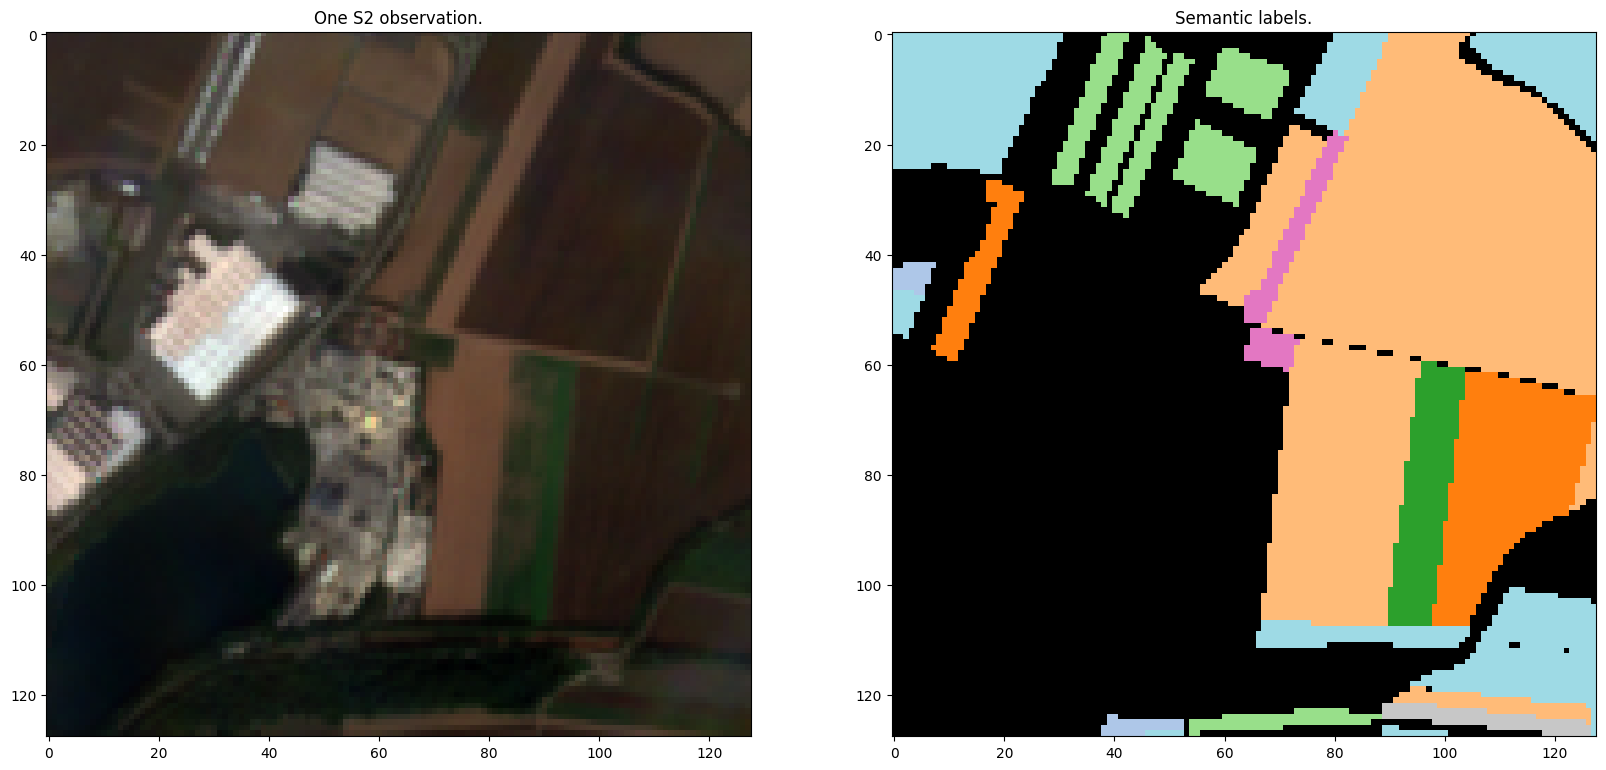

In [74]:
bid = 1 # Which element of the batch to plot

fix, axes = plt.subplots(1,2, figsize=(20,20))

axes[0].imshow(get_rgb(x, batch_index=bid))
axes[1].imshow(y[bid].squeeze(), cmap=cmap, vmin=0, vmax=20)

axes[0].set_title('One S2 observation.')
axes[1].set_title('Semantic labels.')

In [103]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import Nystroem
from matplotlib import pyplot as plt
import xgboost as xgb

In [76]:
x_flat = x['S2'].numpy()
x_flat.shape

(300, 61, 10, 128, 128)

In [77]:
x_flat = x_flat[:, 0, :, :, :]
x_flat.shape

(300, 10, 128, 128)

In [78]:
x_flat = x_flat.reshape([-1, x_flat.shape[1]])
x_flat.shape

(4915200, 10)

In [79]:
# Flatten the labels
y_flat = y.view(-1).numpy()
y_flat.shape

(4915200,)

In [80]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(x_flat, y_flat, test_size=0.33, random_state=42)

print(x_train.shape)
print(y_train.shape)

(3293184, 10)
(3293184,)


In [89]:
svm = LinearSVC(dual='auto')
svm.fit(x_train, y_train)

LinearSVC(dual='auto')

In [81]:
xgb_model = xgb.XGBClassifier(max_depth=8, objective='multi:softprob', n_estimators=500)
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [82]:
y_pred_xgb = xgb_model.predict(x_test)
testing = y_pred_xgb.reshape([-1, 128, 128])
testing[32]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [83]:
xgb_model.score(x_test, y_test)

0.4046353426846591

In [90]:
svm.score(x_test, y_test)

0.40599106297348486

In [41]:
y_pred = svm.predict(x_test)

In [45]:
x_test.shape

(540672, 10)

In [43]:
testing = y_pred.reshape([-1, 128, 128])
testing[32]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [110]:
y_test = y_test.flatten()
y_pred = y_pred.flatten()

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted')

print('Accuracy: ', accuracy)
print('F1: ', f1)
print('Precision: ', precision)
print('Recall: ', recall)

Accuracy:  0.3929425048828125
F1:  0.2216944512818482
Precision:  0.7614613072607667
Recall:  0.3929425048828125


In [96]:
dl_ex = torch.utils.data.DataLoader(dt, batch_size=1, collate_fn=pad_collate, shuffle=True)
(x_ex, dates), y_ex = dl_ex.__iter__().__next__()
# Flatten the time series
x_ex_flat = x_ex['S2'].numpy()
x_ex_flat = x_ex_flat[:, 0, :, :, :]
x_ex_flat = x_ex_flat.reshape([-1, x_flat.shape[1]])

# Flatten the labels
y_ex_flat = y_ex.view(y_ex.shape[0], -1)

Text(0.5, 1.0, 'Semantic labels.')

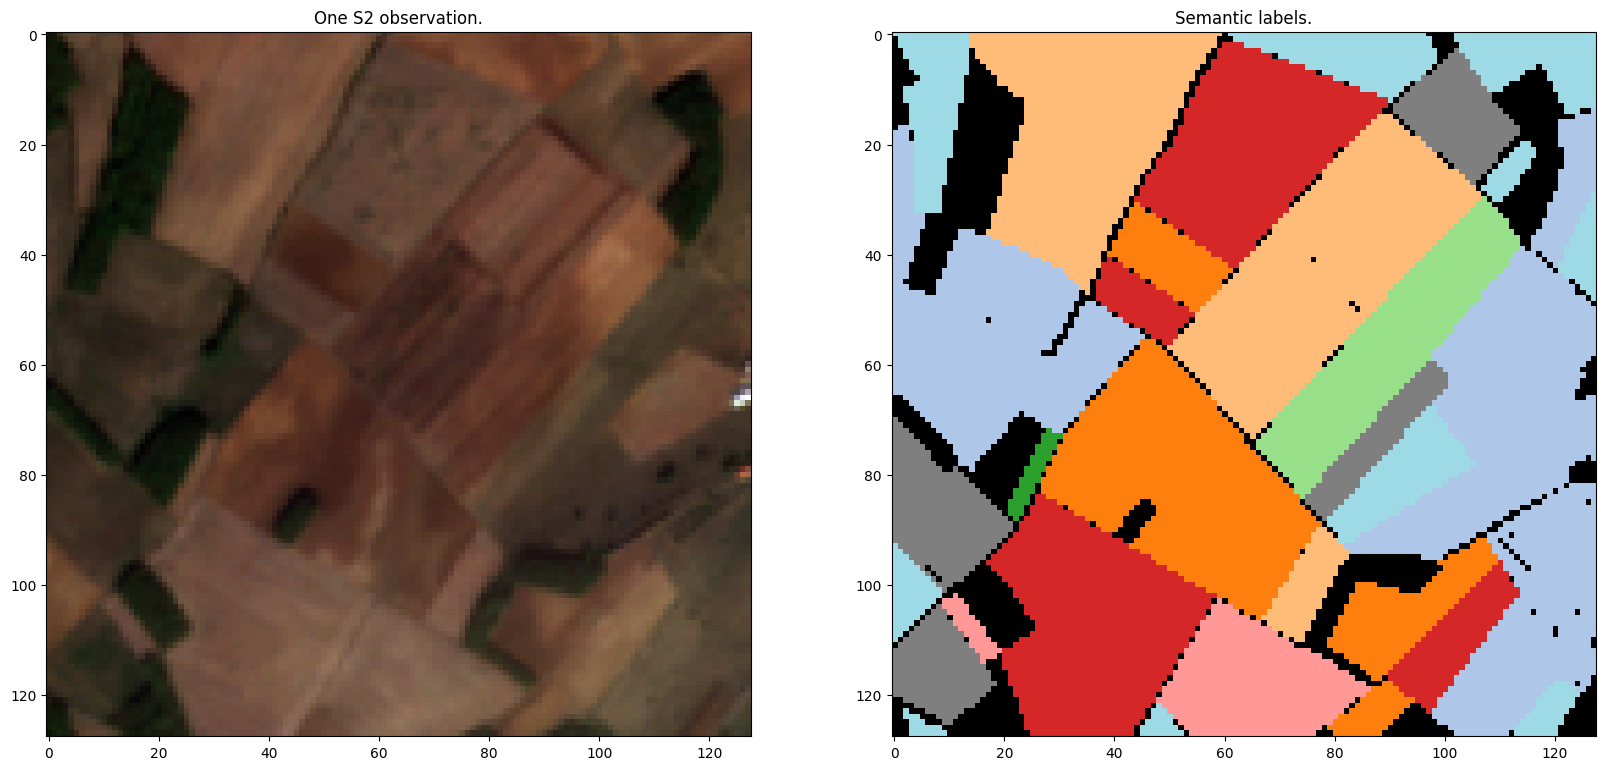

In [97]:
bid = 0 # Which element of the batch to plot

fix, axes = plt.subplots(1,2, figsize=(20,20))

axes[0].imshow(get_rgb(x_ex, batch_index=bid))
axes[1].imshow(y_ex[bid].squeeze(), cmap=cmap, vmin=0, vmax=20)

axes[0].set_title('One S2 observation.')
axes[1].set_title('Semantic labels.')

In [98]:
x_ex_flat.shape

(16384, 10)

In [99]:
y_ex_pred = svm.predict(x_ex_flat)
y_ex_pred = y_ex_pred.reshape([128, 128])

In [100]:
y_ex_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Text(0.5, 1.0, 'Ground Truth')

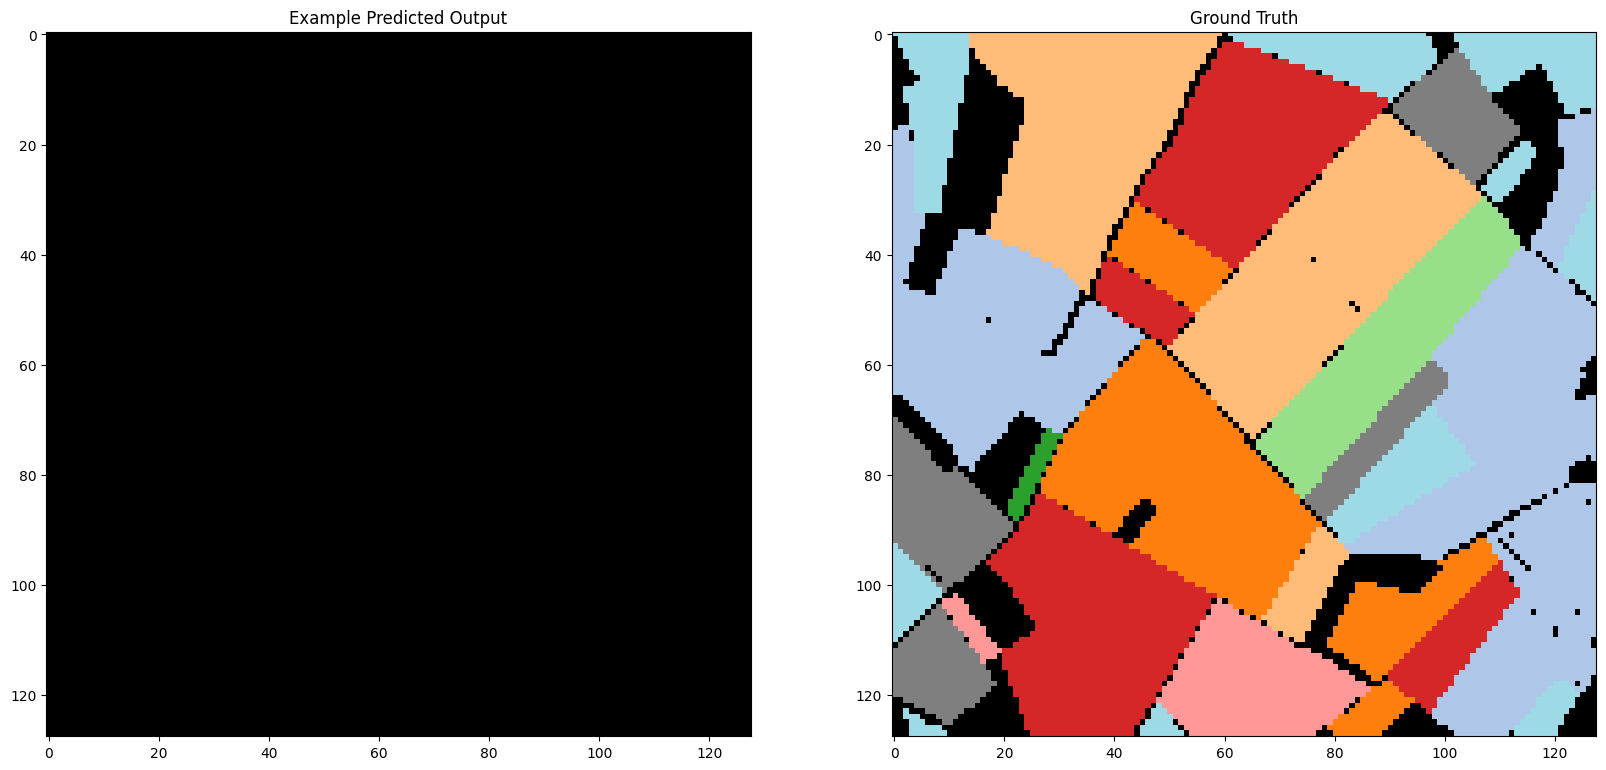

In [101]:
fix, axes = plt.subplots(1,2, figsize=(20,20))

axes[0].imshow(y_ex_pred, cmap=cmap, vmin=0, vmax=20)
axes[1].imshow(y_ex[0].squeeze(), cmap=cmap, vmin=0, vmax=20)

axes[0].set_title('Example Predicted Output')
axes[1].set_title('Ground Truth')